## Embeddings for Weather Data

An embedding is a low-dimensional, vector representation of a (typically) high-dimensional feature which maintains the semantic meaning of the feature in a such a way that similar features are close in the embedding space.

In this notebook, we use autoencoders to create embeddings for HRRR images. We can then use the embeddings to search for "similar" weather patterns.

In [1]:
!sudo apt-get -y --quiet install libeccodes0

Reading package lists...
Building dependency tree...
Reading state information...
libeccodes0 is already the newest version (2.0.2-5).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


In [2]:
%pip install -q cfgrib xarray pydot

Note: you may need to restart the kernel to use updated packages.


In [1]:
import apache_beam as beam
print(beam.__version__)

2.23.0


In [4]:
PROJECT='ai-analytics-solutions'
BUCKET='{}-kfpdemo'.format(PROJECT)

### Reading HRRR data and converting to TensorFlow Records

HRRR data comes in a Grib2 files on Cloud Storage.

In [2]:
!gsutil ls -l gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.*.wrfsfcf00*

 105624174  2020-08-11T00:51:01Z  gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t00z.wrfsfcf00.grib2
      7842  2020-08-11T00:50:39Z  gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t00z.wrfsfcf00.grib2.idx
 104905515  2020-08-11T01:49:31Z  gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t01z.wrfsfcf00.grib2
      7842  2020-08-11T01:49:04Z  gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t01z.wrfsfcf00.grib2.idx
 101942347  2020-08-11T02:48:01Z  gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t02z.wrfsfcf00.grib2
      7840  2020-08-11T02:47:33Z  gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t02z.wrfsfcf00.grib2.idx
 101412287  2020-08-11T03:52:23Z  gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t03z.wrfsfcf00.grib2
      7839  2020-08-11T03:51:52Z  gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t03z.wrfsfcf00.grib2.idx
 101204218  2020-08-11T04:50:36Z  gs://high-resolution-rapid-ref

In [2]:
FILENAME="gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t18z.wrfsfcf06.grib2"   # derecho in the Midwest
!gsutil ls -l {FILENAME}

 128701013  2020-08-11T19:02:22Z  gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t18z.wrfsfcf06.grib2
TOTAL: 1 objects, 128701013 bytes (122.74 MiB)


In [ ]:
import xarray as xr
import tensorflow as tf
import tempfile
import cfgrib

with tempfile.TemporaryDirectory() as tmpdirname:
    TMPFILE="{}/read_grib".format(tmpdirname)
    tf.io.gfile.copy(FILENAME, TMPFILE, overwrite=True)
    ds = cfgrib.open_datasets(TMPFILE)
    print(ds)

We have to choose one of the following:
```
    filter_by_keys={'typeOfLevel': 'unknown'}
    filter_by_keys={'typeOfLevel': 'cloudTop'}
    filter_by_keys={'typeOfLevel': 'surface'}
    filter_by_keys={'typeOfLevel': 'heightAboveGround'}
    filter_by_keys={'typeOfLevel': 'isothermal'}
    filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
    filter_by_keys={'typeOfLevel': 'pressureFromGroundLayer'}
    filter_by_keys={'typeOfLevel': 'sigmaLayer'}
    filter_by_keys={'typeOfLevel': 'meanSea'}
    filter_by_keys={'typeOfLevel': 'heightAboveGroundLayer'}
    filter_by_keys={'typeOfLevel': 'sigma'}
    filter_by_keys={'typeOfLevel': 'depthBelowLand'}
    filter_by_keys={'typeOfLevel': 'isobaricLayer'}
    filter_by_keys={'typeOfLevel': 'cloudBase'}
    filter_by_keys={'typeOfLevel': 'nominalTop'}
    filter_by_keys={'typeOfLevel': 'isothermZero'}
    filter_by_keys={'typeOfLevel': 'adiabaticCondensation'}
```

[1059 1799]
2020-08-11T18:00:00.000000000
2020-08-12T00:00:00.000000000


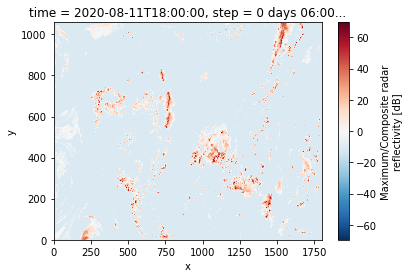

In [5]:
import xarray as xr
import tensorflow as tf
import tempfile
import cfgrib
import numpy as np

refc = 0
with tempfile.TemporaryDirectory() as tmpdirname:
    TMPFILE="{}/read_grib".format(tmpdirname)
    tf.io.gfile.copy(FILENAME, TMPFILE, overwrite=True)
    #ds = xr.open_dataset(TMPFILE, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'surface', 'stepType': 'instant'}})
    #ds.data_vars['prate'].plot()  # crain, prate
    ds = xr.open_dataset(TMPFILE, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'unknown', 'stepType': 'instant'}})
    #ds = xr.open_dataset(TMPFILE, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'atmosphere', 'stepType': 'instant'}})
    refc = ds.data_vars['refc']
    refc.plot()
    print(np.array([refc.sizes['y'], refc.sizes['x']]))
    print(refc.time.data)
    print(refc.valid_time.data)

In [6]:
print(str(refc.time.data)[:19])

2020-08-11T18:00:00


In [8]:
import numpy as np

def _array_feature(value, min_value, max_value):
    """Wrapper for inserting ndarray float features into Example proto."""
    value = np.nan_to_num(value.flatten()) # nan, -inf, +inf to numbers
    value = np.clip(value, min_value, max_value) # clip to valid
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def create_tfrecord(filename):
    with tempfile.TemporaryDirectory() as tmpdirname:
        TMPFILE="{}/read_grib".format(tmpdirname)
        tf.io.gfile.copy(filename, TMPFILE, overwrite=True)
        ds = xr.open_dataset(TMPFILE, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'unknown', 'stepType': 'instant'}})
   
        # create a TF Record with the raw data
        tfexample = tf.train.Example(
            features=tf.train.Features(
                feature={
                    'ref': _array_feature(ds.data_vars['refc'].data, min_value=0, max_value=60),
        }))
        return tfexample.SerializeToString()

s = create_tfrecord(FILENAME)
print(len(s), s[:16])

7620594 b'\n\xed\x8f\xd1\x03\n\xe8\x8f\xd1\x03\n\x03ref\x12'


In [9]:
from datetime import datetime, timedelta
def generate_filenames(startdate: str, enddate: str):
    start_dt = datetime.strptime(startdate, '%Y%m%d')
    end_dt = datetime.strptime(enddate, '%Y%m%d')
    dt = start_dt
    while dt <= end_dt:
        # gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t04z.wrfsfcf00.grib2
        f = '{}/hrrr.{:4}{:02}{:02}/conus/hrrr.t{:02}z.wrfsfcf00.grib2'.format(
                'gs://high-resolution-rapid-refresh',
                dt.year, dt.month, dt.day, dt.hour)
        dt = dt + timedelta(hours=1)
        yield f
        
def generate_shuffled_filenames(startdate: str, enddate: str):
    """
    shuffle the files so that a batch of records doesn't contain highly correlated entries
    """
    filenames = [f for f in generate_filenames(startdate, enddate)]
    np.random.shuffle(filenames)
    return filenames

print(generate_shuffled_filenames('20190915', '20190917'))

['gs://high-resolution-rapid-refresh/hrrr.20190916/conus/hrrr.t09z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190915/conus/hrrr.t20z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190916/conus/hrrr.t00z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190916/conus/hrrr.t06z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190916/conus/hrrr.t17z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190916/conus/hrrr.t15z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190915/conus/hrrr.t22z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190916/conus/hrrr.t01z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190916/conus/hrrr.t03z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190915/conus/hrrr.t21z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190916/conus/hrrr.t02z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190916/conus/hrrr.t20z.wrfsfcf00

## Write a Beam pipeline

In [ ]:
%run -m wxsearch.hrrr_to_tfrecord -- --startdate 20190915 --enddate 20190916  --outdir gs://{BUCKET}/wxsearch/data/2019 --project {PROJECT}
# --outdir tmp

## Read the written TF Records

In [6]:
# try reading what was written out
import tensorflow as tf

def parse_tfrecord(example_data):
    parsed = tf.io.parse_single_example(example_data, {
        'size': tf.io.VarLenFeature(tf.int64),
        'ref': tf.io.VarLenFeature(tf.float32),
        'time': tf.io.FixedLenFeature([], tf.string),
        'valid_time': tf.io.FixedLenFeature([], tf.string)
     })
    parsed['size'] = tf.sparse.to_dense(parsed['size'])
    parsed['ref'] = tf.reshape(tf.sparse.to_dense(parsed['ref']), (1059, 1799))/60. # 0 to 1
    return parsed

def read_dataset(pattern):
    filenames = tf.io.gfile.glob(pattern)
    ds = tf.data.TFRecordDataset(filenames, compression_type=None, buffer_size=None, num_parallel_reads=None)
    return ds.prefetch(tf.data.experimental.AUTOTUNE).map(parse_tfrecord)

ds = read_dataset('gs://{}/wxsearch/data/2019/tfrecord-00000-*'.format(BUCKET))
for refc in ds.take(1):
    print(repr(refc))

{'ref': <tf.Tensor: shape=(1059, 1799), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>, 'size': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1059, 1799])>, 'time': <tf.Tensor: shape=(), dtype=string, numpy=b'2019-06-06T03:00:00'>, 'valid_time': <tf.Tensor: shape=(), dtype=string, numpy=b'2019-06-06T03:00:00'>}


## Create autoencoder in Keras

In [117]:
## A model without the intermediate Dense layer, so that end result is effectively tiled
## We use more filters to represent the tiles

import tensorflow as tf
def create_model(nlayers=4, poolsize=4, numfilters=5, num_dense=0):
    input_img = tf.keras.Input(shape=(1059, 1799, 1), name='refc_input')

    x = tf.keras.layers.Cropping2D(cropping=((17, 18),(4, 3)), name='cropped')(input_img)
    last_pool_layer = None
    for layerno in range(nlayers):
        x = tf.keras.layers.Conv2D(2**(layerno + numfilters), poolsize, activation='relu', padding='same', name='encoder_conv_{}'.format(layerno))(x)
        last_pool_layer = tf.keras.layers.MaxPooling2D(poolsize, padding='same', name='encoder_pool_{}'.format(layerno))
        x = last_pool_layer(x)
    output_shape = last_pool_layer.output_shape[1:]
    
    if num_dense == 0:
        # flatten to create the embedding
        x = tf.keras.layers.Flatten(name='refc_embedding')(x)
        embed_size = output_shape[0] * output_shape[1] * output_shape[2]
        if embed_size > 1024:
            print("Embedding size={} is too large".format(embed_size))
            return None, embed_size
    else:
        # flatten, send through dense layer to create the embedding
        x = tf.keras.layers.Flatten(name='encoder_flatten')(x)
        x = tf.keras.layers.Dense(num_dense, name='refc_embedding')(x)
        x = tf.keras.layers.Dense(output_shape[0] * output_shape[1] * output_shape[2], name='decoder_dense')(x)
        embed_size = num_dense
        
    x = tf.keras.layers.Reshape(output_shape, name='decoder_reshape')(x)
    for layerno in range(nlayers):
        x = tf.keras.layers.Conv2D(2**(nlayers-layerno-1 + numfilters), poolsize, activation='relu', padding='same', name='decoder_conv_{}'.format(layerno))(x)
        x = tf.keras.layers.UpSampling2D(poolsize, name='decoder_upsamp_{}'.format(layerno))(x)
    before_padding_layer = tf.keras.layers.Conv2D(1, 3, activation='relu', padding='same', name='before_padding')
    x = before_padding_layer(x)
    htdiff = 1059 - before_padding_layer.output_shape[1]
    wddiff = 1799 - before_padding_layer.output_shape[2]
    if htdiff < 0 or wddiff < 0:
        print("Invalid architecture: htdiff={} wddiff={}".format(htdiff, wddiff))
        return None, 9999
    decoded = tf.keras.layers.ZeroPadding2D(padding=((htdiff//2,htdiff - htdiff//2),
                                                     (wddiff//2,wddiff - wddiff//2)), name='refc_reconstructed')(x)

    autoencoder = tf.keras.Model(input_img, decoded, name='autoencoder')
    autoencoder.compile(optimizer='adam', loss=tf.keras.losses.LogCosh()) #loss='mse')
    if autoencoder.count_params() > 1000*1000: # 1 million      
        print("Autoencoder too large: {} params".format(autoencoder.count_params()))
        return None, autoencoder.count_params()
    
    return autoencoder, embed_size

autoencoder, sz = create_model(4, 4, 4, 50)
if autoencoder:
    print(sz, autoencoder.count_params())
    autoencoder.summary()

50 969123
Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
refc_input (InputLayer)      [(None, 1059, 1799, 1)]   0         
_________________________________________________________________
cropped (Cropping2D)         (None, 1024, 1792, 1)     0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 1024, 1792, 16)    272       
_________________________________________________________________
encoder_pool_0 (MaxPooling2D (None, 256, 448, 16)      0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 256, 448, 32)      8224      
_________________________________________________________________
encoder_pool_1 (MaxPooling2D (None, 64, 112, 32)       0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 64, 112, 

## Train the autoencoder

In [ ]:
def input_and_label(rec):
    return rec['ref'], rec['ref']

ds = read_dataset('gs://{}/wxsearch/data/2019/tfrecord-00000-*'.format(BUCKET)).map(input_and_label).batch(2).repeat()
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoints')
history = autoencoder.fit(ds, steps_per_epoch=1, epochs=3, shuffle=True, callbacks=[checkpoint])
print(history)

In [ ]:
autoencoder.save('tmp/savedmodel')

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss']);

In [ ]:
%run -m wxsearch.train_autoencoder -- --input gs://{BUCKET}/wxsearch/data/2019/tfrecord-00000-*  --outdir gs://{BUCKET}/wxsearch/trained --project {PROJECT}

## Run at scale

In [ ]:
%run -m wxsearch.hrrr_to_tfrecord -- --startdate 20190101 --enddate 20200101  --outdir gs://{BUCKET}/wxsearch/data/2019 --project {PROJECT}

<img src="dataflow_2019.png" />

In [5]:
%%writefile train.yaml
trainingInput:
  scaleTier: CUSTOM
  masterType: n1-highmem-2
  masterConfig:
    acceleratorConfig:
      count: 2
      type: NVIDIA_TESLA_K80
  runtimeVersion: '2.2'
  pythonVersion: '3.7'
  scheduling:
    maxWaitTime: 3600s

Overwriting train.yaml


In [1]:
%%bash

PROJECT=$(gcloud config get-value project)
echo ${PROJECT}
BUCKET="ai-analytics-solutions-kfpdemo"
PACKAGE_PATH="${PWD}/wxsearch"
now=$(date +"%Y%m%d_%H%M%S")
JOB_NAME="wxsearch_$now"
MODULE_NAME="wxsearch.train_autoencoder"
JOB_DIR="gs://${BUCKET}/wxsearch/train/jobdir"
REGION="us-central1"

# 9000 images in dataset
gcloud ai-platform jobs submit training $JOB_NAME \
        --package-path $PACKAGE_PATH \
        --module-name $MODULE_NAME \
        --job-dir $JOB_DIR \
        --region $REGION \
        --config train.yaml \
        -- \
        --input gs://${BUCKET}/wxsearch/data/2019/tfrecord-* \
        --outdir gs://${BUCKET}/wxsearch/trained \
        --project ${PROJECT} \
        --batch_size 4 --num_steps 10000 --num_checkpoints 10

ai-analytics-solutions
jobId: wxsearch_20201009_010505
state: QUEUED


Job [wxsearch_20201009_010505] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe wxsearch_20201009_010505

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs wxsearch_20201009_010505


## Try out the autoencoder

Load the Keras model, and try out the autoencoder functionality.

In [1]:
import tensorflow as tf
model = tf.keras.models.load_model('gs://ai-analytics-solutions-kfpdemo/wxsearch/trained/savedmodel')

In [2]:
embed_output = model.get_layer('refc_embedding').output
embedder = tf.keras.Model(model.input, embed_output, name='embedder')
print(embedder.summary())

Model: "embedder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
refc_input (InputLayer)      [(None, 1059, 1799, 1)]   0         
_________________________________________________________________
cropped (Cropping2D)         (None, 1024, 1792, 1)     0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 1024, 1792, 16)    272       
_________________________________________________________________
encoder_pool_0 (MaxPooling2D (None, 256, 448, 16)      0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 256, 448, 32)      8224      
_________________________________________________________________
encoder_pool_1 (MaxPooling2D (None, 64, 112, 32)       0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 64, 112, 64)       328

In [10]:
import tensorflow as tf
PROJECT='ai-analytics-solutions'
BUCKET='{}-kfpdemo'.format(PROJECT)
print(BUCKET)

def parse_tfrecord(example_data):
    parsed = tf.io.parse_single_example(example_data, {
        'size': tf.io.VarLenFeature(tf.int64),
        'ref': tf.io.VarLenFeature(tf.float32),
        'time': tf.io.FixedLenFeature([], tf.string),
        'valid_time': tf.io.FixedLenFeature([], tf.string)
     })
    parsed['size'] = tf.sparse.to_dense(parsed['size'])
    parsed['ref'] = tf.reshape(tf.sparse.to_dense(parsed['ref']), (1059, 1799))/60. # 0 to 1
    return parsed

def read_dataset(pattern):
    filenames = tf.io.gfile.glob(pattern)
    ds = tf.data.TFRecordDataset(filenames, compression_type=None, buffer_size=None, num_parallel_reads=None)
    return ds.prefetch(tf.data.experimental.AUTOTUNE).map(parse_tfrecord)

ds = read_dataset('gs://{}/wxsearch/data/2019/tfrecord-00000-*'.format(BUCKET))
for rec in ds.take(1):
    print(rec['ref'])
    refc = tf.expand_dims(tf.expand_dims(rec['ref'], 0), -1)
    x = embedder.predict(refc)
    print(tf.squeeze(x, axis=0))

ai-analytics-solutions-kfpdemo
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(1059, 1799), dtype=float32)
tf.Tensor(
[ 0.301531    1.1230749  -0.11051312 -0.7169816   0.41527277 -0.2514371
  0.45809814 -0.1219312   0.6078904  -0.24121551  0.51386464 -0.15141343
 -0.18161477  0.5419359  -0.02541194  0.1649076   0.43065113  0.691609
 -0.23777175 -0.2843141  -0.63672084  0.65880483  0.24391702 -0.07345533
 -0.08864652 -0.14317618  0.38981095 -0.4006542   0.21685484  0.90802234
 -0.12074046  0.14775434 -0.02762385 -0.47858676 -0.09548081 -0.3523487
  0.38083994 -0.19541779 -0.19363467  0.07926624 -0.2369798   0.24522418
  1.0302618  -0.0429398  -0.3022312   0.48221755 -0.2893774   0.20048837
  0.04749289 -0.00721024], shape=(50,), dtype=float32)


In [11]:
print(tf.__version__)

2.3.0


In [8]:
!gsutil ls gs://ai-analytics-solutions-kfpdemo/wxsearch/data/2019/

CommandException: One or more URLs matched no objects.


In [ ]:
%run -m wxsearch.compute_embedding -- --output_table {PROJECT}:advdata.wxembed --savedmodel gs://{BUCKET}/wxsearch/trained/savedmodel --input gs://{BUCKET}/wxsearch/data/2019/tfrecord-* --outdir gs://{BUCKET}/wxsearch/tmp --project {PROJECT}

## Try decoding

In [1]:
%%bigquery df
SELECT *
FROM advdata.wxembed

In [2]:
df.head(n=5)

,size,ref,time,valid_time
0,"[1059, 1799]","[-0.3423147201538086, -0.2379823625087738, 0.1...",2019-09-20 05:00:00+00:00,2019-09-20 05:00:00+00:00
1,"[1059, 1799]","[-0.11114707589149475, 0.2925637364387512, -0....",2019-08-16 10:00:00+00:00,2019-08-16 10:00:00+00:00
2,"[1059, 1799]","[0.37308964133262634, 0.1036672368645668, -0.1...",2019-10-28 23:00:00+00:00,2019-10-28 23:00:00+00:00
3,"[1059, 1799]","[0.3508044183254242, 0.20376038551330566, -0.0...",2019-07-20 11:00:00+00:00,2019-07-20 11:00:00+00:00
4,"[1059, 1799]","[-0.08892631530761719, 0.10215485841035843, -0...",2019-08-08 20:00:00+00:00,2019-08-08 20:00:00+00:00


Let's decode the first row. First, we create a decoder

In [3]:
import tensorflow as tf
def create_decoder(model_dir):
    model = tf.keras.models.load_model(model_dir)
    decoder_input = tf.keras.Input([50], name='embed_input')
    embed_seen = False
    x = decoder_input
    for layer in model.layers:
        if embed_seen:
            x = layer(x)
        elif layer.name == 'refc_embedding':
            embed_seen = True
    decoder = tf.keras.Model(decoder_input, x, name='decoder')
    print(decoder.summary())
    return decoder

decoder = create_decoder('gs://ai-analytics-solutions-kfpdemo/wxsearch/trained/savedmodel')

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed_input (InputLayer)     [(None, 50)]              0         
_________________________________________________________________
decoder_dense (Dense)        (None, 3584)              182784    
_________________________________________________________________
decoder_reshape (Reshape)    (None, 4, 7, 128)         0         
_________________________________________________________________
decoder_conv_0 (Conv2D)      (None, 4, 7, 128)         262272    
_________________________________________________________________
decoder_upsamp_0 (UpSampling (None, 16, 28, 128)       0         
_________________________________________________________________
decoder_conv_1 (Conv2D)      (None, 16, 28, 64)        131136    
_________________________________________________________________
decoder_upsamp_1 (UpSampling (None, 64, 112, 64)       0   

Then, we invoke decoder.predict() to reconstruct the image from the 50 numbers in the embedding.

In [4]:
import tensorflow as tf
import numpy as np
embed = tf.reshape( tf.convert_to_tensor(df['ref'].values[0], dtype=tf.float32), [-1, 50])
outimg = decoder.predict(embed).squeeze() * 60
print(len(df['ref'].values[0]))
print(np.max(outimg))

50
31.765097


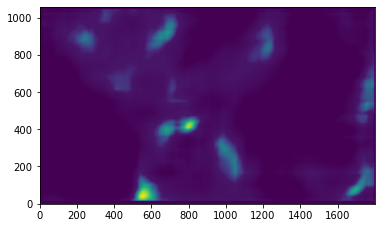

In [5]:
import matplotlib.pyplot as plt
plt.imshow(outimg, origin='lower');

What does the original look like? Let's pull the original HRRR Grib file from this time stamp

gs://high-resolution-rapid-refresh/hrrr.20190920/conus/hrrr.t05z.wrfsfcf00.grib2


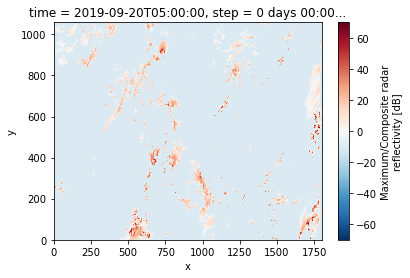

In [3]:
import pandas as pd
dt = pd.Timestamp(df['time'].values[0])
# gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t04z.wrfsfcf00.grib2
FILENAME = '{}/hrrr.{:4}{:02}{:02}/conus/hrrr.t{:02}z.wrfsfcf00.grib2'.format(
                'gs://high-resolution-rapid-refresh',
                dt.year, dt.month, dt.day, dt.hour)
print(FILENAME)

import xarray as xr
import tensorflow as tf
import tempfile
import cfgrib
import numpy as np

refc = 0
with tempfile.TemporaryDirectory() as tmpdirname:
    TMPFILE="{}/read_grib".format(tmpdirname)
    tf.io.gfile.copy(FILENAME, TMPFILE, overwrite=True)
    #ds = xr.open_dataset(TMPFILE, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'surface', 'stepType': 'instant'}})
    #ds.data_vars['prate'].plot()  # crain, prate
    ds = xr.open_dataset(TMPFILE, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'unknown', 'stepType': 'instant'}})
    #ds = xr.open_dataset(TMPFILE, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'atmosphere', 'stepType': 'instant'}})
    refc = ds.data_vars['refc']
    refc.plot()

## Searching for similar images

Suppose we want to find an image similar to the above image. 

In [1]:
%%bigquery
WITH ref1 AS (
SELECT time AS ref1_time, ref1_value, ref1_offset
FROM `ai-analytics-solutions.advdata.wxembed`,
     UNNEST(ref) AS ref1_value WITH OFFSET AS ref1_offset
WHERE time = '2019-09-20 05:00:00 UTC'
)

SELECT 
  time,
  SUM( (ref1_value - ref[OFFSET(ref1_offset)]) * (ref1_value - ref[OFFSET(ref1_offset)]) ) AS sqdist 
FROM ref1, `ai-analytics-solutions.advdata.wxembed`
GROUP BY 1
ORDER By sqdist ASC
LIMIT 5

,time,sqdist
0,2019-09-20 05:00:00+00:00,0.000000
1,2019-09-20 06:00:00+00:00,0.519979
2,2019-09-20 04:00:00+00:00,0.546595
3,2019-09-20 07:00:00+00:00,1.001852
4,2019-09-20 03:00:00+00:00,1.387520


This makes a lot of sense. The image from the previous/next hour is the most similar.
Then, images from +/- 2 hours ...

What if we want to find the most similar image that is not within +/- 1 day?
Since we have only 1 year of data, we are not going to great analogs, possibly,
but let's see what we get.

In [2]:
%%bigquery df
WITH ref1 AS (
SELECT time AS ref1_time, ref1_value, ref1_offset
FROM `ai-analytics-solutions.advdata.wxembed`,
     UNNEST(ref) AS ref1_value WITH OFFSET AS ref1_offset
WHERE time = '2019-09-20 05:00:00 UTC'
)

SELECT 
  time,
  SUM( (ref1_value - ref[OFFSET(ref1_offset)]) * (ref1_value - ref[OFFSET(ref1_offset)]) ) AS sqdist 
FROM ref1, `ai-analytics-solutions.advdata.wxembed`
WHERE time NOT BETWEEN '2019-09-19' AND '2019-09-21'
GROUP BY 1
ORDER By sqdist ASC
LIMIT 5

In [3]:
df

,time,sqdist
0,2019-01-02 00:00:00+00:00,5.125657
1,2019-01-01 23:00:00+00:00,5.160568
2,2019-07-01 18:00:00+00:00,5.226617
3,2019-01-02 02:00:00+00:00,5.240267
4,2019-07-01 19:00:00+00:00,5.244619


Really, Jan. 2 in 2019 had similar weather to Sep 20? Let's see ...

gs://high-resolution-rapid-refresh/hrrr.20190102/conus/hrrr.t00z.wrfsfcf00.grib2


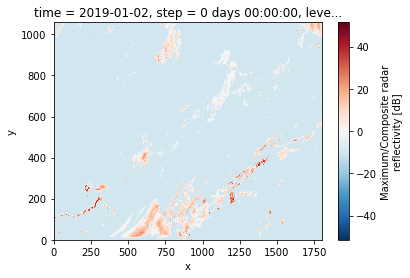

In [4]:
import pandas as pd
dt = pd.Timestamp(df['time'].values[0])
# gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t04z.wrfsfcf00.grib2
FILENAME = '{}/hrrr.{:4}{:02}{:02}/conus/hrrr.t{:02}z.wrfsfcf00.grib2'.format(
                'gs://high-resolution-rapid-refresh',
                dt.year, dt.month, dt.day, dt.hour)
print(FILENAME)

import xarray as xr
import tensorflow as tf
import tempfile
import cfgrib
import numpy as np

refc = 0
with tempfile.TemporaryDirectory() as tmpdirname:
    TMPFILE="{}/read_grib".format(tmpdirname)
    tf.io.gfile.copy(FILENAME, TMPFILE, overwrite=True)
    #ds = xr.open_dataset(TMPFILE, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'surface', 'stepType': 'instant'}})
    #ds.data_vars['prate'].plot()  # crain, prate
    ds = xr.open_dataset(TMPFILE, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'unknown', 'stepType': 'instant'}})
    #ds = xr.open_dataset(TMPFILE, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'atmosphere', 'stepType': 'instant'}})
    refc = ds.data_vars['refc']
    refc.plot()

What about July 1, 2019, which is next on the list?

gs://high-resolution-rapid-refresh/hrrr.20190701/conus/hrrr.t18z.wrfsfcf00.grib2


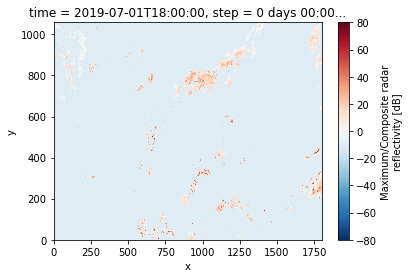

In [5]:
import pandas as pd
dt = pd.Timestamp(df['time'].values[2])
# gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t04z.wrfsfcf00.grib2
FILENAME = '{}/hrrr.{:4}{:02}{:02}/conus/hrrr.t{:02}z.wrfsfcf00.grib2'.format(
                'gs://high-resolution-rapid-refresh',
                dt.year, dt.month, dt.day, dt.hour)
print(FILENAME)

import xarray as xr
import tensorflow as tf
import tempfile
import cfgrib
import numpy as np

refc = 0
with tempfile.TemporaryDirectory() as tmpdirname:
    TMPFILE="{}/read_grib".format(tmpdirname)
    tf.io.gfile.copy(FILENAME, TMPFILE, overwrite=True)
    #ds = xr.open_dataset(TMPFILE, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'surface', 'stepType': 'instant'}})
    #ds.data_vars['prate'].plot()  # crain, prate
    ds = xr.open_dataset(TMPFILE, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'unknown', 'stepType': 'instant'}})
    #ds = xr.open_dataset(TMPFILE, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'atmosphere', 'stepType': 'instant'}})
    refc = ds.data_vars['refc']
    refc.plot()

Both these have weather in approximately the same places. On Jan 1, things are more widespread than in July.
The date we searched for (May) is somewhere in between the Jan and July weather scenarios ...

To make the search work better, we should use smaller tiles (not the whole country, but perhaps 500kmx500km tiles). Then, we'll get mesoscale phenomena.

Enjoy!

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License